# Run a REopt API evaluation

## Initialization

In [8]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
from src.post_and_poll import get_api_results
API_KEY = 'uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC'  # REPLACE WITH YOUR API KEY

In [9]:
# following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [10]:
"""
Here are some convenience definitions for using the Multi-scenario capabilities
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Load a previously saved API response .json file instead of running REopt

In [4]:
response_json = 'results'
with open(os.path.join(outputs_path, response_json + '.json'), 'rb') as handle:
    api_response = json.load(handle)

## Scenario Inputs (POST), if wanting to do a new API call

In [57]:
post_1 = {"Scenario": {
    "optimality_tolerance_techs": 0.001,
    "Site": {
        "longitude": -106.5527591,
        "latitude": 35.0488506,
        "land_acres": 1.0e6,
        "roof_squarefeet": 1.0e9,
        # "renewable_electricity_min_pct": 0.0,
        # "renewable_electricity_max_pct": 0.0,
        # "co2_emissions_reduction_min_pct": None,
        # "co2_emissions_reduction_max_pct": None, # even if None or 1.0, this will trigger emissions constraints
        "off_grid_flag": False,
        "include_climate_in_objective": False,
        "LoadProfile": {
            "loads_kw": [],  # Populated below
            "critical_load_pct": 1.0,  # Modeling all load = critical load
            # "critical_loads_kw": [],  # Not needed, using loads_kw and critical_load_pct = 1.0
            # "outage_start_time_step": 5000,  # defined below
            # "outage_end_time_step": 5000 + 168*2,  # defined below
            "outage_is_major_event": True,  # Not used in the optimization, only for value of lost load
            "year": 2017,  # Consistent with using CRB's which we pre-process and combine into an aggregated load below
        },
        "ElectricTariff": {
            "blended_annual_rates_us_dollars_per_kwh": 0.04,
            "blended_annual_demand_charges_us_dollars_per_kw": 0.0,
            "wholesale_rate_us_dollars_per_kwh": 0.04
        },
        "Generator": {
            "min_kw": 0.0,        
            "max_kw": 1000000000.0,
            "diesel_fuel_cost_us_dollars_per_gallon": 3.0,        
            "installed_cost_us_dollars_per_kw": 800.0,  # From Jimmy
            "om_cost_us_dollars_per_kw": 20.0,
            "om_cost_us_dollars_per_kwh": 0.0,        
            "fuel_slope_gal_per_kwh": 0.08217,  # 30% HHV efficiency 
            "fuel_intercept_gal_per_hr": 0.0,
            "fuel_avail_gal": 1000000.0,
            "min_turn_down_pct": 0.1,
            "existing_kw": 0.0,
            "generator_only_runs_during_grid_outage": True,
            "generator_sells_energy_back_to_grid": False,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
        },      
        "PV": {
            "installed_cost_us_dollars_per_kw": 1256.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021
            "om_cost_us_dollars_per_kw": 22.0,  # From Dan's analysis, NOT REopt default, ATB 2020
            "array_type": 2,
            "federal_itc_pct": 0.0,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
            "macrs_itc_reduction": 0.0
        },
        "Wind": {
            "max_kw": 1.0e6,
            "installed_cost_us_dollars_per_kw": 1437.0,  # From Jimmy, ATB 2021
            "om_cost_us_dollars_per_kw": 40.0,  # REopt default
            "federal_itc_pct": 0.0,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
            "macrs_itc_reduction": 0.0            
        },
        "Storage": {
            "installed_cost_us_dollars_per_kw": 406.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021 UTILITY SCALE SEEMS WAY LOW
            "installed_cost_us_dollars_per_kwh": 197.0,  # From Dan's analysis, NOT From Jimmy, ATB 2021 UTILITY SCALE
            "replace_cost_us_dollars_per_kw": 406/2.0,  # Assume half cost for inverter replacement
            "replace_cost_us_dollars_per_kwh": 197.0/2.0,  # Assume half cost for battery pack replacement
            "can_grid_charge": True,
            "macrs_option_years": 0,
            "macrs_bonus_pct": 0.0,
            "macrs_itc_reduction": 0.0,
            "total_itc_pct": 0,
        },
        "Financial": {
            "om_cost_escalation_pct": 0.0,
            "escalation_pct": 0.0,
            "generator_fuel_escalation_pct": 0.0,
            "offtaker_tax_pct": 0.0,
            "offtaker_discount_pct": 0.03,
            "analysis_years": 25,
            "co2_cost_us_dollars_per_tonne": 0.0  # Only used if Site.include_climate_in_objective = True
        }
}}}

### Load in EACI (cricital) load data for Kirtland microgrid

In [16]:
load_data_monthly = pd.read_excel('./load_profiles/INCOMPLETE_MG5_LoadMonthlyEnergyData_ProfileTypes_2019_JEQ_02222022.xlsx', index_col=0)

In [17]:
load_data_monthly.head(3)

,20245,20202,20332,20201,20210,21002,20130,20203,20200,20325,20129,20107,20206
Type,MediumOffice,FlatLoad_16_7,FlatLoad_16_7,SmallOffice,FlatLoad,FlatLoad,MediumOffice,MediumOffice,SmallOffice,FlatLoad,FlatLoad_8_5,FlatLoad_8_7,RetailStore
1,56340,70280,92400,0,16880,7289,64440,34440,40080,40360,62880,6180,2600
2,53640,50920,86400,0,13720,5188,58640,33400,33760,35400,56160,5280,2200


In [18]:
load_data_monthly["20245"]["Type"]

'MediumOffice'

In [75]:
root_url = "https://developer.nrel.gov/api/reopt/v1/"
endpoint = "simulated_load"
api_url = root_url + endpoint + '/?api_key=' + API_KEY
building_load_profiles = {}
for building in load_data_monthly.columns:
    data = load_data_monthly[building]
    resp = requests.get(url=api_url, verify=False, params={
            'load_type': "electric",
            'doe_reference_name': data["Type"],
            'monthly_totals_kwh[0]': data[1],
            'monthly_totals_kwh[1]': data[2],
            'monthly_totals_kwh[2]': data[3],
            'monthly_totals_kwh[3]': data[4],
            'monthly_totals_kwh[4]': data[5],
            'monthly_totals_kwh[5]': data[6],
            'monthly_totals_kwh[6]': data[7],
            'monthly_totals_kwh[7]': data[8],
            'monthly_totals_kwh[8]': data[9],
            'monthly_totals_kwh[9]': data[10],
            'monthly_totals_kwh[10]': data[11],
            'monthly_totals_kwh[11]': data[12],
            # 'doe_reference_name[0]': bldg[0],
            # 'doe_reference_name[1]': bldg[1],
            # 'percent_share[0]': percent_share[0],
            # 'percent_share[1]': percent_share[1],
            'latitude': post_1["Scenario"]["Site"]["latitude"],
            'longitude': post_1["Scenario"]["Site"]["longitude"]
        })
    building_load_data = json.loads(resp.text)
    building_load_profiles[building] = building_load_data["loads_kw"]

In [76]:
building_load_profiles["all"] = np.zeros(8760)
for building in load_data_monthly.columns:
    building_load_profiles["all"] = building_load_profiles["all"] + np.array(building_load_profiles[building])
building_load_profiles["all"] = list(building_load_profiles["all"])
building_load_profiles_df = pd.DataFrame.from_dict(building_load_profiles)

In [ ]:
# Add timestamp for 2017 calendar from which the CRB loads are synced with
from datetime import datetime, timedelta
# Function below INCLUDES the end_date/last datetime
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date <= end_date:
        yield start_date
        start_date += delta
start_date = datetime(2017, 1, 1, 0, 00)
end_date = datetime(2017, 12, 31, 23, 00)
building_load_profiles_df.index = daterange(start_date, end_date)
building_load_profiles_df.to_csv("./load_profiles/building_load_profiles.csv")

In [58]:
# OVERRIDING PROCESSED LOAD PROFILES WITH THE ONE JIMMY SENT WITH THE MISSING BUILDING, FOR NOW
building_load_profiles_df = pd.read_csv('./load_profiles/building_load_profiles_03082022_JEQ.csv', index_col=0)

In [53]:
import matplotlib.pyplot as plt
import random

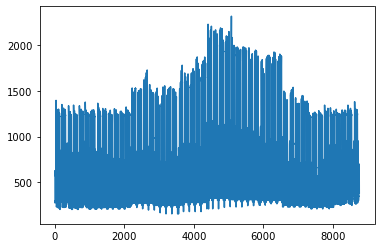

In [54]:
plt.plot(building_load_profiles_df["All"].values)

In [59]:
# Determine which load will be used for the electric load profile and critical load
post_1["Scenario"]["Site"]["LoadProfile"]["loads_kw"] = list(building_load_profiles_df["All"].values)
# From post_1 definition above, critical_load_pct = 1 which is what we want

### Load in a custom electric rate generated from https://reopt.nrel.gov/tool/custom_tariffs

In [6]:
load_electric_rate = "PGE_E20"
with open(os.path.join(rates_path, load_electric_rate + ".json"), 'r') as fp:
    rate_1 = json.load(fp)
post_1["Scenario"]["Site"]["ElectricTariff"]["urdb_response"] = rate_1

## Save the POST to a .json file for sharing or future loading in

In [7]:
# Convert python dictionary post into json and save to a .json file
post_save = post_1
post_name = "post_1"
with open(os.path.join(inputs_path, post_name + ".json"), 'w') as fp:
    json.dump(post_save, fp)

## Or load in a saved .json file for the inputs/POST

In [8]:
# Load a json into a python dictionary
load_post = "post_1"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_1 = json.load(fp)

## POST and poll (periodic GET request) the API to GET a new result, if not loading in a previous response. This may take a while!

### Note, the `api_url` in the `get_api_results` function below calls the **production server** hosted API (master/main branch/version, publicly accessible)

#### For calling a locally-hosted (localhost) API, see:
- https://github.com/NREL/REopt_Lite_API/wiki/localhost-URLs-for-calling-locally-hosted-API

#### For calling an API hosted on an NREL-internal server (only NREL users can access this), see:
- https://github.nrel.gov/REopt/API_scripts/wiki/API-URLs-for-NREL-internal-servers

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

A log file is also created in the current working directory.

In [60]:
for i in range(1,10):
    outage_start = random.randint(1, 8760)
    post_1["Scenario"]["Site"]["LoadProfile"]["outage_start_time_step"] = outage_start
    post_1["Scenario"]["Site"]["LoadProfile"]["outage_end_time_step"] = outage_start + 168*2
    outputs_file_name = "outage_start_" + str(outage_start)
    root_url = "https://developer.nrel.gov/api/reopt/v1"
    api_response = get_api_results(post=post_1, 
                                   API_KEY=API_KEY, 
                                   api_url=root_url, 
                                   results_file=os.path.join(outputs_path, outputs_file_name + ".json"), 
                                   run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/v1/job/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC.
main         INFO     Polling https://developer.nrel.gov/api/reopt/v1/job/95d64cda-7755-4e24-9ebc-2be9eabc3174/results/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC for results with interval of 5s...
main         INFO     Saved results to ./outputs/outage_start_1221.json
main         INFO     Response OK from https://developer.nrel.gov/api/reopt/v1/job/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC.
main         INFO     Polling https://developer.nrel.gov/api/reopt/v1/job/7f166584-04aa-40ed-8108-bdb265ea8d4d/results/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC for results with interval of 5s...
main         INFO     Saved results to ./outputs/outage_start_8265.json
main         INFO     Response OK from https://developer.nrel.gov/api/reopt/v1/job/?api_key=uiMp56xYMT983T2OikI0RrEKAyAAEDpZHzuC8nTC.
main         INFO     Polling https://develope

### If you get disconnected from the polling function but you think it ran, copy the run_uuid from the log above to manually GET the results:

In [48]:
run_uuid = api_response["outputs"]["Scenario"]["run_uuid"]
print("run_uuid = ", api_response["outputs"]["Scenario"]["run_uuid"])
results_url = root_url + '/job/' + run_uuid + '/results/?api_key=' + API_KEY
resp = requests.get(url=results_url, verify=False)
api_response = json.loads(resp.text)

run_uuid =  5d642d04-5d36-45c6-bb42-7d0fc74c9c3f


## Get summary of results

In [49]:
print("NPV ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["npv_us_dollars"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Scenario"]["Site"]["Financial"]["net_capital_costs"])
tech_list = ["PV", "Wind", "Storage", "CHP", "Generator", "HotTES", "ColdTES", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post_1["Scenario"]["Site"].keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"]["Scenario"]["Site"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
        for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])
    elif tech in ["PV", "Storage"]:
        for size_name_value in [(key, val) for key, val in api_response["outputs"]["Scenario"]["Site"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])                

NPV ($) =  -4202242.0
Capital Cost, Net ($) =  5125237.02
PV size_kw  =  1577.1865
Wind size_kw  =  594.8529
Storage size_kw  =  524.8343817119356
Storage size_kwh  =  775.3953878566319
Generator size_kw  =  1122.661542175364


In [72]:
# Create a dictionary with all of the outage start time responses
directory = './outputs'
responses = {}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        if "outage_start_" in filename:
            dict_data = json.load(open(f, 'rb'))
            outage_start = dict_data["inputs"]["Scenario"]["Site"]["LoadProfile"]["outage_start_time_step"]
            responses[outage_start] = json.load(open(f, 'rb'))

In [73]:
pv_kw = []
battery_kw = []
battery_kwh = []
wind_kw = []
gen_kw = []
npv = []
for start, data in responses.items():
    pv_kw.append(data["outputs"]["Scenario"]["Site"]["PV"]["size_kw"])
    battery_kw.append(data["outputs"]["Scenario"]["Site"]["Storage"]["size_kw"])
    battery_kwh.append(data["outputs"]["Scenario"]["Site"]["Storage"]["size_kwh"])
    wind_kw.append(data["outputs"]["Scenario"]["Site"]["Wind"]["size_kw"])
    gen_kw.append(data["outputs"]["Scenario"]["Site"]["Generator"]["size_kw"]) 
    npv.append(data["outputs"]["Scenario"]["Site"]["Financial"]["npv_us_dollars"])

Text(0.5, 1.0, 'REopt sizing results for different outage start times')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
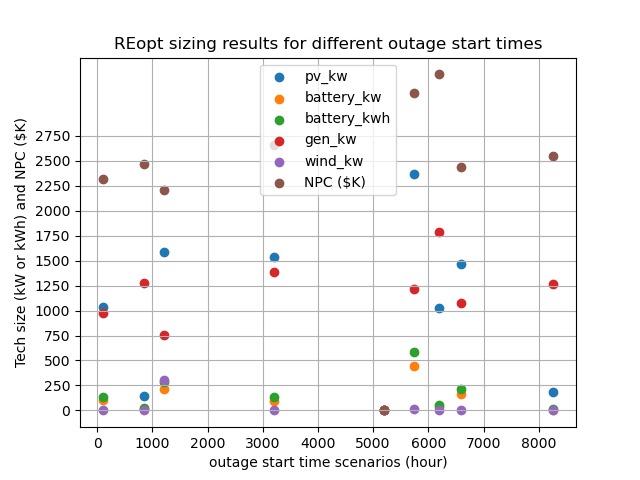

In [112]:
%matplotlib widget
plt.scatter(responses.keys(), [pv_kw[i] or 0 for i in range(len(pv_kw))], label="pv_kw")
plt.scatter(responses.keys(), [battery_kw[i] or 0 for i in range(len(battery_kw))], label="battery_kw")
plt.scatter(responses.keys(), [battery_kwh[i] or 0 for i in range(len(battery_kwh))], label="battery_kwh")
plt.scatter(responses.keys(), [gen_kw[i] or 0 for i in range(len(gen_kw))], label="gen_kw")
plt.scatter(responses.keys(), [wind_kw[i] or 0 for i in range(len(wind_kw))], label="wind_kw")
plt.scatter(responses.keys(), [(npv[i] or 0)*-1/1E3 for i in range(len(npv))], label="NPC ($K)")
plt.yticks(np.arange(0, 3000, 250))
plt.grid()
plt.legend()
plt.ylabel("Tech size (kW or kWh) and NPC ($K)")
plt.xlabel("outage start time scenarios (hour)")
plt.title("REopt sizing results for different outage start times")

### Here are some results keys examples:

In [12]:
api_response.keys()

dict_keys(['outputs', 'inputs', 'messages'])

In [14]:
api_response["outputs"]["Scenario"]["status"]

'optimal'

In [16]:
for k in api_response["outputs"]["Scenario"]["Site"].keys():
    print(k)

year_one_emissions_lb_C02
year_one_emissions_bau_lb_C02
outdoor_air_temp_degF
renewable_electricity_energy_pct
Financial
LoadProfile
LoadProfileBoilerFuel
LoadProfileChillerThermal
ElectricTariff
FuelTariff
Storage
Generator
Wind
CHP
Boiler
ElectricChiller
AbsorptionChiller
HotTES
ColdTES
NewBoiler
SteamTurbine
GHP
PV


## Save API response into a JSON file for later use

In [17]:
response_save = api_response
file_name_to_save = "response_1"
with open(os.path.join(outputs_path, file_name_to_save + ".json"), 'w') as fp:
    json.dump(response_save, fp)